In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [23]:
import sys
sys.path.append('../scripts')
import data_cleaning as cd

In [24]:
### Import data sources ###

# Training data
train = pd.read_csv('../data/train.csv')

#Previously purchased subscriptions by account
subscriptions = pd.read_csv('../data/subscriptions.csv')
#display(subscriptions.head())

# Location info for each patron and donation history
accounts = pd.read_csv('../data/account.csv')
#display(accounts.head())

# Previous concerts by season
concerts = pd.read_csv('../data/concerts.csv')
#display(concerts.head())

# List of planned concert sets for the 2014-15 season
planned_concerts = pd.read_csv('../data/concerts_2014-15.csv')
#display(planned_concerts.head())

# Previously purchased tickets by account
tickets = pd.read_csv('../data/tickets_all.csv')
#display(tickets.head())

# Location and demographic information for zipcodes
zipcodes = pd.read_csv('../data/zipcodes.csv')
#display(zipcodes.head())

# Final test data
final_test = pd.read_csv('../data/test.csv')

In [25]:
subscriptions, accounts, concerts, planned_concerts, tickets, zipcodes = cd.clean_data(subscriptions, accounts, concerts, planned_concerts, tickets, zipcodes)

Missing subscriptions data:  account.id              0
season                  0
package                 6
no.seats                0
location                6
section              4543
price.level          3534
subscription_tier       0
multiple.subs           0
dtype: int64 out of 28627 

Dropping rows with missing data...
Initial length of subscriptions:  28627
Length of subscriptions after cleaning:  24083
Missing accounts data:  account.id                     0
shipping.zip.code          19569
billing.zip.code            2955
shipping.city              19561
billing.city                2218
relationship               19172
amount.donated.2013            0
amount.donated.lifetime        0
no.donations.lifetime          0
first.donated              14298
dtype: int64 out of 19833 

Dropping rows with missing data...
Initial length of accounts:  19833
Length of accounts after cleaning:  1
Missing concerts data:  season          0
concert.name    0
set             0
who             0
w

/Users/jc/code/kaggle/philarmoniab-kaggle/notebooks/../scripts/data_cleaning.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets['price.level'] = label_encoder.fit_transform(tickets['price.level'])


In [26]:
print("Training set:")
# check how many account_id from training data are present in the other data sources
print("Subscriptions account ids: ")
display(pd.Series(train['account.id'].unique()).isin(subscriptions['account.id']).value_counts())

print("Accounts account ids: ")
display(pd.Series(train['account.id'].unique()).isin(accounts['account.id']).value_counts())

print("Tickets account ids: ")
display(pd.Series(train['account.id'].unique()).isin(tickets['account.id']).value_counts())

print("\nTest set:")
# check how many account_id from test data are present in the other data sources
print("Subscriptions account ids: ")
display(pd.Series(final_test['ID'].unique()).isin(subscriptions['account.id']).value_counts())

print("Accounts account ids: ")
display(pd.Series(final_test['ID'].unique()).isin(accounts['account.id']).value_counts())

print("Tickets account ids: ")
display(pd.Series(final_test['ID'].unique()).isin(tickets['account.id']).value_counts())

Training set:
Subscriptions account ids: 


False    4868
True     2073
Name: count, dtype: int64

Accounts account ids: 


False    6941
Name: count, dtype: int64

Tickets account ids: 


False    6214
True      727
Name: count, dtype: int64


Test set:
Subscriptions account ids: 


False    2093
True      882
Name: count, dtype: int64

Accounts account ids: 


False    2975
Name: count, dtype: int64

Tickets account ids: 


False    2683
True      292
Name: count, dtype: int64

In [27]:
def add_features(X):
    if 'ID' not in X.columns:
        X['ID'] = X['account.id']

    # Subscription features
    subscriptions_by_account = pd.DataFrame({'num_subscriptions':subscriptions.groupby(by=['account.id']).size()}).reset_index()
    # Add total subscriptions by account id (if can't find, then 0)
    X['num_subscriptions'] = X['ID'].map(subscriptions_by_account.set_index('account.id')['num_subscriptions'])
    # Assuming that if account doesn't appear on subscriptions data, then they have no subscriptions
    X['num_subscriptions'] = X['num_subscriptions'].fillna(0)
    # Add average subscription price level by account id (if can't find, then 0)
    X['avg_subscription_price_level'] = X['ID'].map(subscriptions.groupby(['account.id'])['price.level'].mean())
    X['avg_subscription_price_level'] = X['avg_subscription_price_level'].fillna(0)
    # Add average subscription tier by account id (if can't find, then 0)
    X['avg_subscription_tier'] = X['ID'].map(subscriptions.groupby(['account.id'])['subscription_tier'].mean())
    X['avg_subscription_tier'] = X['avg_subscription_tier'].fillna(0) 

    # Ticket features
    tickets_by_account = pd.DataFrame({'num_tickets':tickets.groupby(['account.id']).size()}).reset_index()
    # Add total tickets by account id (if can't find, then 0)
    X['num_tickets'] = X['ID'].map(tickets_by_account.set_index('account.id')['num_tickets'])
    # Assuming that if account doesn't appear on tickets data, then they have no tickets
    X['num_tickets'] = X['num_tickets'].fillna(0)

    # Add total tickets just for the 2013-2014 season by account id (if can't find, then 0)
    X['num_tickets_2013'] = X['ID'].map(tickets[tickets['season'] == '2013-2014'].groupby(['account.id'])['no.seats'].sum())
    X['num_tickets_2013'] = X['num_tickets_2013'].fillna(0)

    # Add average ticket price level by account id (if can't find, then 0)
    X['avg_ticket_price_level'] = X['ID'].map(tickets.groupby(['account.id'])['price.level'].mean())
    X['avg_ticket_price_level'] = X['avg_ticket_price_level'].fillna(0)

    # Add total number of seats by account id (if can't find, then 0)
    X['num_seats'] = X['ID'].map(tickets.groupby(['account.id'])['no.seats'].sum())
    X['num_seats'] = X['num_seats'].fillna(0)

    # Add total number of seats just for the 2013-2014 season by account id (if can't find, then 0)
    X['num_seats_2013'] = X['ID'].map(tickets[tickets['season'] == '2013-2014'].groupby(['account.id'])['no.seats'].sum())
    X['num_seats_2013'] = X['num_seats_2013'].fillna(0)

    display(X.head())

    return X

In [28]:
def train_lr(X_train_scaled, y_train, X_test_scaled, y_test):
    acc_scores = []
    c_vals = np.arange(0.1,5,0.1)
    for c in c_vals:
        model = LogisticRegression(penalty='l2',C=c)
        scores = cross_val_score(model,X_train_scaled,y_train,scoring='accuracy',cv=5)
        acc_scores.append(np.mean(scores))

    plt.plot(c_vals,acc_scores)
    opt_c = c_vals[np.argmax(acc_scores)]
    plt.title('Optimal penalty C is {:.3f}'.format(opt_c))
    plt.xlabel('C (1/lambda)')
    plt.ylabel('Cross-validated accuracy score')
    plt.show()


    # Retrain the final model on the full training set and calculate the test set accuracy
    final_model = LogisticRegression(penalty='l2',C=opt_c,random_state=0)
    final_model.fit(X_train_scaled,y_train)
    test_preds = final_model.predict(X_test_scaled)
    acc_score = accuracy_score(y_test,test_preds)
    print('Accuracy on test set is {:.3f}'.format(acc_score))

    return final_model

In [29]:
def calc_feature_importances(model,feat_names,num_to_show):
    # Determine the relative importance of each feature using the random forest model
    importances = model.feature_importances_
    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:num_to_show][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()
    return RF_ranking

In [30]:
def train_random_forest(columns, X_train_scaled, y_train, X_test_scaled, y_test):
    params = {'min_samples_leaf':[1,3,10],'n_estimators':[100,1000],
          'max_features':[0.1,0.5,1.],'max_samples':[0.5,None]}

    model = RandomForestClassifier()
    grid_search = GridSearchCV(model,params,cv=3)
    grid_search.fit(X_train_scaled,y_train)

    bp = grid_search.best_params_

    print(bp)

    rf_model = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=bp['min_samples_leaf'],n_estimators=bp['n_estimators'],
                                 max_features=bp['max_features'],max_samples=bp['max_samples'])
    
    rf_model.fit(X_train_scaled, y_train)

    top_feats = 30
    calc_feature_importances(rf_model,columns,top_feats)
    
    test_preds = rf_model.predict(X_test_scaled)
    test_acc = np.sum(test_preds==y_test)/len(y_test)
    print('Test set accuracy is {:.3f}'.format(test_acc))
    print('Test set AUROC is {:.3f}'.format(roc_auc_score(y_test,test_preds)))

    return rf_model
    

,account.id,label,ID,num_subscriptions,avg_subscription_price_level,avg_subscription_tier,num_tickets,num_tickets_2013,avg_ticket_price_level,num_seats,num_seats_2013
0,001i000000NuRo3,0,001i000000NuRo3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,001i000000NuRxd,0,001i000000NuRxd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001i000000NuQGN,0,001i000000NuQGN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,001i000000NuPfL,0,001i000000NuPfL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001i000000NuQkP,0,001i000000NuQkP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Feat Index,Feature,Importance
0,0,num_subscriptions,0.501165
1,1,avg_subscription_price_level,0.276762
2,2,avg_subscription_tier,0.151757
3,5,avg_ticket_price_level,0.024949
4,6,num_seats,0.020369
5,3,num_tickets,0.016040
6,4,num_tickets_2013,0.004533
7,7,num_seats_2013,0.004426


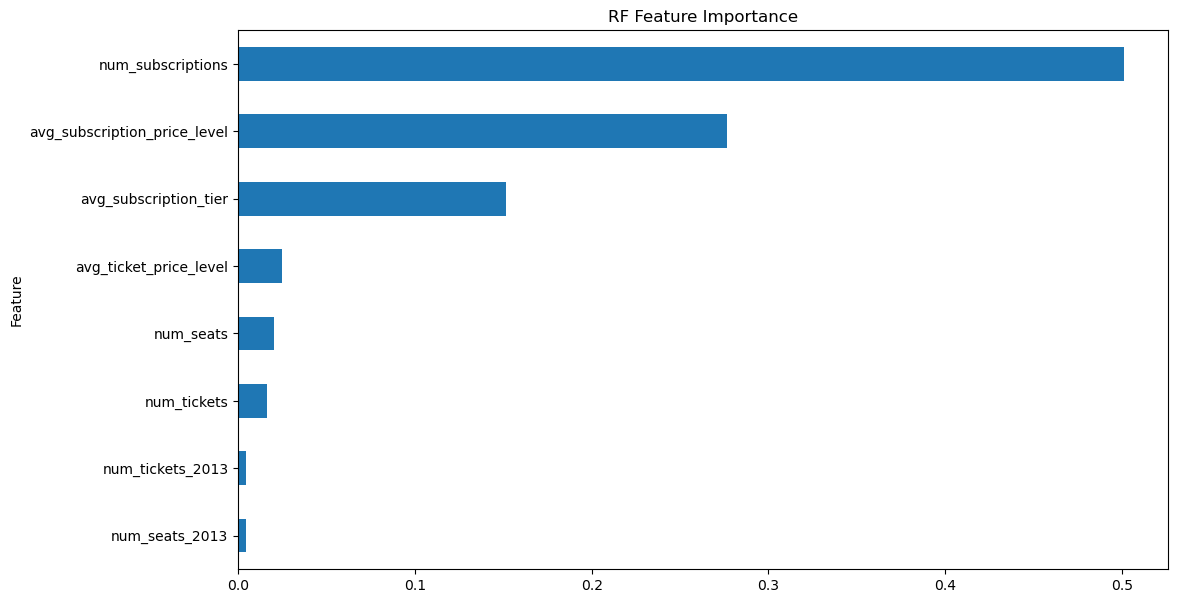

Test set accuracy is 0.965
Training accuracy:  0.9713616714697406


In [31]:
X_train = train.copy()

X_train = add_features(X_train)

X = X_train.drop(['account.id', 'ID', 'label'], axis=1)
y = train['label']

X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = train_random_forest(X.columns, X_train_scaled, y_train, X_test_scaled, y_test)
    
#model = train_lr(X_train_scaled, y_train, X_test_scaled, y_test)

model.fit(X_train,y_train)

preds = model.predict(X_train)
print("Training accuracy: ", np.mean(preds == y_train))



In [32]:
X_test = final_test.copy()

X_test = add_features(X_test)

X_test = X_test.drop(['ID'], axis=1)

preds = model.predict(X_test)

final_test['Predicted'] = preds

final_test[['ID', 'Predicted']].to_csv('../data/submission.csv', index=False)

print("Submission file created!")

,ID,num_subscriptions,avg_subscription_price_level,avg_subscription_tier,num_tickets,num_tickets_2013,avg_ticket_price_level,num_seats,num_seats_2013
0,001i000000NuQ6Y,5.0,1.0,1.8,0.0,0.0,0.0,0.0,0.0
1,001i000000NuQXz,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
2,001i000000NuRDC,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0
3,001i000000NuQeg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001i000000NuOQc,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


Submission file created!
